In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn import metrics
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df_train = pd.read_csv("df_train.csv")
df_valid = pd.read_csv("df_valid.csv")
df_test = pd.read_csv("df_test.csv")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25600 entries, 0 to 25599
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  25600 non-null  int64 
 1   Unnamed: 0    25600 non-null  int64 
 2   headline      25600 non-null  object
 3   clickbait     25600 non-null  int64 
 4   clean_text    25600 non-null  object
dtypes: int64(3), object(2)
memory usage: 1000.1+ KB


In [4]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(df_train['clean_text'])
sequences = tok.texts_to_sequences(df_train['clean_text'])
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
valid_sequences = tok.texts_to_sequences(df_valid['clean_text'])
valid_sequences_matrix = sequence.pad_sequences(valid_sequences,maxlen=max_len)


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.optimizers import RMSprop

# Define the RNN model
def RNN(max_len, max_words):
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 50, input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256, name='FC1')(layer)
    outputs = Dense(1, activation='sigmoid', name='output')(layer)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define your max_len and max_words values
max_len = 150 # Example value, replace with your actual maximum sequence length
max_words = 10000  # Example value, replace with your actual vocabulary size

# Create the RNN model
model = RNN(max_len, max_words)
model.summary()

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           500000    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 output (Dense)              (None, 1)                 257       
                                                                 
Total params: 546337 (2.08 MB)
Trainable params: 546337 (2.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


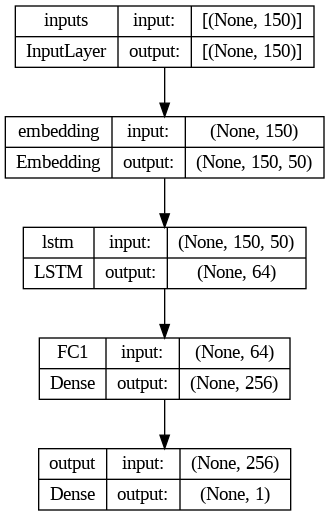

In [6]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
plot_model(model, show_shapes=True, show_layer_names=True)

In [7]:
lstm = model.fit(sequences_matrix,df_train['clickbait'],batch_size=128,epochs=50,validation_data=(valid_sequences_matrix,df_valid['clickbait']))

Epoch 1/50
200/200 [==============================] - 23s 80ms/step - loss: 0.2259 - accuracy: 0.9019 - val_loss: 0.1298 - val_accuracy: 0.9522
Epoch 2/50
200/200 [==============================] - 2s 12ms/step - loss: 0.1034 - accuracy: 0.9613 - val_loss: 0.1284 - val_accuracy: 0.9559
Epoch 3/50
200/200 [==============================] - 2s 11ms/step - loss: 0.0957 - accuracy: 0.9644 - val_loss: 0.1300 - val_accuracy: 0.9541
Epoch 4/50
200/200 [==============================] - 2s 9ms/step - loss: 0.0917 - accuracy: 0.9664 - val_loss: 0.1259 - val_accuracy: 0.9534
Epoch 5/50
200/200 [==============================] - 3s 13ms/step - loss: 0.0869 - accuracy: 0.9677 - val_loss: 0.1291 - val_accuracy: 0.9550
Epoch 6/50
200/200 [==============================] - 2s 10ms/step - loss: 0.0836 - accuracy: 0.9688 - val_loss: 0.1333 - val_accuracy: 0.9553
Epoch 7/50
200/200 [==============================] - 2s 8ms/step - loss: 0.0857 - accuracy: 0.9688 - val_loss: 0.1317 - val_accuracy: 0.9563


In [8]:
test_sequences = tok.texts_to_sequences(df_test['clean_text'])
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [9]:
# accr = model.evaluate(test_sequences_matrix,y_test)

In [10]:
# Evaluate the model
loss, accuracy = model.evaluate(test_sequences_matrix, df_test['clickbait'])

# Make predictions
y_pred = model.predict(test_sequences_matrix)
y_pred_binary = (y_pred > 0.5).astype(int)

100/100 [==============================] - 1s 3ms/step


In [11]:
print('Classification Report for LSTM:')
print(classification_report(df_test['clickbait'], y_pred_binary))

Classification Report for LSTM:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1600
           1       0.96      0.95      0.96      1600

    accuracy                           0.96      3200
   macro avg       0.96      0.96      0.96      3200
weighted avg       0.96      0.96      0.96      3200



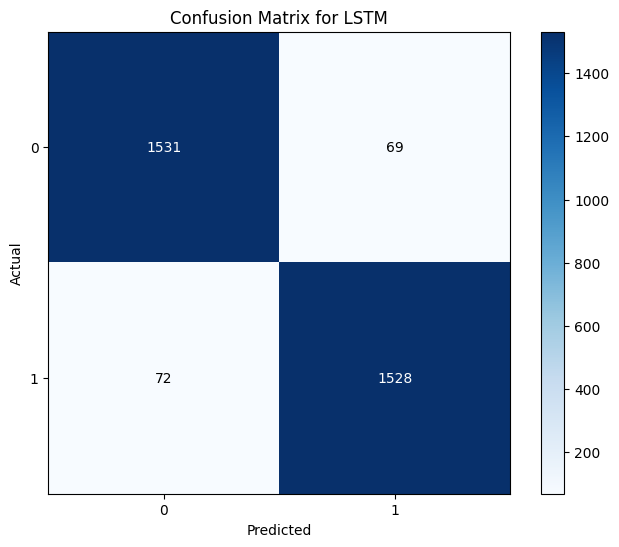

0.9559375


In [12]:
# Create the confusion matrix
cm = metrics.confusion_matrix(df_test['clickbait'], y_pred_binary)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Add labels and ticks
classes = [0, 1]  # Replace with your class labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for LSTM")

# Annotate the heatmap with the counts
thresh = cm.max() / 2
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()
print(metrics.accuracy_score(df_test['clickbait'], y_pred_binary))



In [13]:
cm = metrics.confusion_matrix(df_test['clickbait'], y_pred_binary)
cm

array([[1531,   69],
       [  72, 1528]])

In [14]:
from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(df_test['clickbait'], y_pred_binary)

print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.9559
